# place holder

Author: Prakrut Kansara, edited by Kris Su

Description:

Date created: 


In [40]:
import xarray as xr 
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import box
from tqdm import tqdm

forecast in the past will be hindcast,

the only things will change is the time step: for each month in Jan 2023 up to october of 2024 hindcast going 6 months into the future. 

## Functions

In [6]:
## Function to read and save forecast data ##
## Create function to read data and save it in RAM as xarray Dataset
def read_trim_forecast(file_path, va):
    """
    Args:
        file_path (str): directory of 
        va (str): variable we will be looking for 

    Return:
        forecast_data (xarray.core.dataset.Dataset): trimmed dataset
    """
    try:
        forecast_data = xr.open_dataset(file_path)[va]
        
        # if initialization_date != None:
           # forecast_data = forecast_data.sel(time=initialization_date)
        # else:
            #forecast_data = forecast_data.sel(time=-1)

        return forecast_data
    
    except KeyError:
        print(f'Variable {va} not found in dataset')

In [7]:
## Function to read and save hindcast data ##
## Create function to read data and save it as netcdf file ##
def read_trim_hindcast(file_path, va):
    """
    Args:
        file_path (str): file path to hindcast data
        va (str): variable we will be looking for in the datatset
    Returns:
        hindcast_data (xarray.core.dataset.Dataset):
    """

    try:
        hindcast_data = xr.open_mfdataset(file_path)[va].chunk(dict(time=-1))
        return hindcast_data
    except KeyError:
        print(f'Variable {va} not found in dataset')

In [8]:
## Function to calculate threshold for forecast categories defined by quantiles
def get_thresh(icat, quantiles, xrds, dims=['ensemble','time']):
    """
    Args:
        icat (int): the ith category, for looping through three categories
        quantiles (list): pre-defined boundaries for ranking
        xrds (xarray.core.dataset.Dataset): xarray dataset of forecast 
        dims (list): get thresh for each variables for 
    
    Returns:
        xrds_lo (xarray.core.dataset.Dataset): lower threshold 
        xrds_hi (xarray.core.dataset.Dataset): higher threshold 
    """
    
    if not all(elem in xrds.dims for elem in dims): 
        raise Exception('Some of the dimensions in {} is not present in the xr.Dataset {}'.format(dims,xrds))

    else:
        if icat == 0: # category 0
            xrds_lo = -np.inf
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
        elif icat == len(quantiles): # category MAX
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims) 
            xrds_hi = np.inf # the upper bound extent to positive infinite
        else:
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
    
    return xrds_lo, xrds_hi

In [9]:
## Function to calculate probabilities for tercile categories by counting members within each category
def calculate_probabilities(hcst, fcst, quantiles = [1/3., 2/3.]):
    """
    Args:
        hcst (xarray.core.dataset.Dataset): hindcast data
        fcst (xarray.core.dataset.Dataset): forecast data
        quantiles (list): pre-defined boundaries for ranking

    Returns:
        probs (xarray.core.dataset.Dataset): 

    """
    print('Computing probabilities...')
    numcategories = len(quantiles)+1 # there are 3 categories in total

    # Mask out 0 values in forecast (set to nan)
    fcst_masked = fcst.where(fcst != 0)

    l_probs=list() # initialize empty list
    for icat in range(numcategories): # for each category
        print(f'category={icat}')
        h_lo, h_hi = get_thresh(icat, quantiles, hcst)
        prob = np.logical_and(fcst_masked>h_lo, fcst_masked<=h_hi).sum('ensemble')/float(fcst_masked.sizes['ensemble'])
        # Instead of using the coordinate 'quantile' coming from the hindcast xr.Dataset
        # we will create a new coordinate called 'category'
        #print(prob)

        #print(prob.coords)

        if 'quantile' in prob.coords:
            prob = prob.drop_vars('quantile')
        
        l_probs.append(prob.assign_coords({'category':icat}))
    
    #print(l_probs)
    probs = xr.concat(l_probs,dim='category')
    # print(f'Saving {aggr} tercile probs netCDF files')
    # probs.to_netcdf(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

    return probs

In [10]:
## Function to calculate two-category probabilities for CEMADEN ##
## Only save the data for above normal category air temperature and below normal precipitation ##

"""def calculate_two_ways_probabilities(hindcast, forecast, model, variable, initialization_date):
    cemaden_probs = calculate_probabilities(hindcast, forecast, quantiles=[1/2.])*100

    if variable=='prec':
        cemaden_probability = xr.Dataset(data_vars = {'below_normal':(['L','Y','X'],cemaden_probs.sel(category=0)[variable].data)}, 
                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), 
                                            attrs=forecast.attrs)
    elif variable=='tref':
        cemaden_probability = xr.Dataset(data_vars = {'above_normal':(['L','Y','X'],cemaden_probs.sel(category=1)[variable].data)}, 
                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), 
                                            attrs=forecast.attrs)
        
    ## Save the forecast data to a netcdf file ##
    year = forecast.time.dt.year.values
    month = forecast.time.dt.month.values
    day = forecast.time.dt.day.values

    cemaden_probability.to_netcdf(output_directory + initialization_date.replace('-','_') + '/cemaden_two_probability_' + model + '_' + variable + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(day).zfill(2) + '.nc')

    print('CEMADEN: Two probability categories calculated and saved for NMME hindcast data for ' + model + ' for ' + variable + '!')"""

"def calculate_two_ways_probabilities(hindcast, forecast, model, variable, initialization_date):\n    cemaden_probs = calculate_probabilities(hindcast, forecast, quantiles=[1/2.])*100\n\n    if variable=='prec':\n        cemaden_probability = xr.Dataset(data_vars = {'below_normal':(['L','Y','X'],cemaden_probs.sel(category=0)[variable].data)}, \n                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), \n                                            attrs=forecast.attrs)\n    elif variable=='tref':\n        cemaden_probability = xr.Dataset(data_vars = {'above_normal':(['L','Y','X'],cemaden_probs.sel(category=1)[variable].data)}, \n                                            coords=dict(L=forecast.L.values,Y=forecast.Y.values, X=forecast.X.values), \n                                            attrs=forecast.attrs)\n        \n    ## Save the forecast data to a netcdf file ##\n    year = forecast.time.dt.year.values\n    month = f

In [ ]:
def extract_river_network_with_attributes(data_array, anomalies_array, flow_threshold):
    """
    Extract a river network from an xarray.DataArray and associate streamflow values as attributes.
    
    Parameters:
    - data_array: xarray.DataArray containing streamflow values.
    - flow_threshold: float, the streamflow threshold to define a river channel.
    
    Returns:
    - GeoDataFrame of polylines with streamflow attributes.
    """
    polylines = []
    attributes = []
    
    x_coords = data_array['lon'].values  # Longitude or X-axis values
    y_coords = data_array['lat'].values  # Latitude or Y-axis values
    data = data_array.values  # 2D NumPy array of streamflow values
    anomalies_data = anomalies_array.values

    # Iterate over the grid to find river cells
    for i in range(data.shape[0] - 1):  # Rows (y-dimension)
        for j in range(data.shape[1] - 1):  # Columns (x-dimension)
            # Check if the streamflow in the cell meets the threshold
            print(data[i, j]) # Debugging line to check values
            if np.isfinite(data[i, j]) and data[i, j] >= flow_threshold: #
                # Create a LineString representing the flow path (along the grid edges)
                coords = [
                    (x_coords[j], y_coords[i]),  # Top-left corner
                    (x_coords[j + 1], y_coords[i]),  # Top-right corner
                    (x_coords[j + 1], y_coords[i + 1]),  # Bottom-right corner
                    (x_coords[j], y_coords[i + 1]),  # Bottom-left corner
                    (x_coords[j], y_coords[i]),  # Close the loop
                ]
                polylines.append(LineString(coords)) 
                attributes.append({"streamflow": anomalies_data[i, j]})  # Add streamflow value as an attribute

    # Create a GeoDataFrame from the extracted polylines and attributes
    gdf = gpd.GeoDataFrame(attributes, geometry=polylines, crs="EPSG:4326")  # Adjust CRS as needed
    return gdf

In [47]:
def as_2d(da, xdim="lon", ydim="lat"):
    # Drop size-1 dims
    da = da.squeeze(drop=True)
    # Reduce any leftover non-spatial dims (e.g., ensemble/step/time) to mean
    reduce_dims = [d for d in da.dims if d not in (ydim, xdim)]
    if reduce_dims:
        da = da.mean(dim=reduce_dims, skipna=True)
    # Ensure order is (lat, lon)
    return da.transpose(ydim, xdim)

def extract_river_network_with_attributes(data_array, anomalies_array, flow_threshold):
    da2d  = as_2d(data_array)
    an2d  = as_2d(anomalies_array)
    lon   = da2d["lon"].values
    lat   = da2d["lat"].values
    data  = da2d.values
    anom  = an2d.values

    # mask of cells that pass threshold
    mask = np.isfinite(data) & (data >= flow_threshold)
    ii, jj = np.where(mask)

    # Build cell polygons (EPSG:4326 assumes lat/lon grid)
    geoms = [
        box(lon[j], lat[i+1], lon[j+1], lat[i])   # careful: lat usually descends; adjust if needed
        for i, j in zip(ii, jj) if i+1 < len(lat) and j+1 < len(lon)
    ]

    attrs = [{"streamflow": float(data[i, j]), "anomaly": float(anom[i, j])}
             for i, j in zip(ii, jj) if i+1 < len(lat) and j+1 < len(lon)]

    return gpd.GeoDataFrame(attrs, geometry=geoms, crs="EPSG:4326")

## Executable

In [12]:
workspace_directory = rf'C:\Users\Kris\Documents\amazonforecast\data\hindcast'
surface_model_file_path = workspace_directory + rf'\amazon_forecast'
forecast_data_file_path = surface_model_file_path + rf"\ldas_fcst_2024_dec01.nc"

year = 2024
month = 'dec'

hindcast_data_file_path = []
for i in range(2001, year):
    hindcast_data_file_path.append(surface_model_file_path + os.path.join(f"/ldas_fcst_{i}_{month}01.nc"))
#hindcast_data_file_path

## Global variables
list_of_variables = {'Rainf_tavg' : 'Average precipitation', 
                    'Qair_f_tavg' : 'Specific humidity',
                    'Qs_tavg':'Surface runoff',
                    'Evap_tavg':'Evapotranspiration',
                    'Tair_f_tavg':'Avg. air temperature',
                    'SoilMoist_inst': 'Soil moisture',
                    'SoilTemp_inst': 'Soil temperature',
                    'Streamflow_tavg': 'Stream flow'}

"""
surface_variable_unit = {'Rainf_tavg':'mm/day',
                         'Qair_f_tavg':'g/kg',
                         'Qs_tavg':'mm/day', 
                         'Evap_tavg':'mm/day',
                         'Tair_f_tavg':'degree Celsius', 
                         'SoilMoist_inst':'m^3 m-3', 
                         'SoilTemp_inst':'degree Celsius'}
"""

"\nsurface_variable_unit = {'Rainf_tavg':'mm/day',\n                         'Qair_f_tavg':'g/kg',\n                         'Qs_tavg':'mm/day', \n                         'Evap_tavg':'mm/day',\n                         'Tair_f_tavg':'degree Celsius', \n                         'SoilMoist_inst':'m^3 m-3', \n                         'SoilTemp_inst':'degree Celsius'}\n"

In [ ]:
for variable, variable_longname  in tqdm(list_of_variables.items):

    #, variable_longname in zip(surface_variable_short, surface_variable_long):
    print(variable_longname)

    hindcast = read_trim_hindcast(hindcast_data_file_path, va=variable)

    initialization_date = '2024-12-31'
    forecast  = read_trim_forecast(forecast_data_file_path, variable)

    probs = calculate_probabilities(hindcast, forecast) *100

    max_prob = probs.max(dim='category') # get the maximum probability value across the three categories
    mask = probs != max_prob # create a mask where values are not equal to the max probability
    probs_with_nan = xr.where(mask, np.nan, probs) # set non-maximum probability values to NaN

    file_savepath = './get_ldas_probabilistics_output' + '/prob_' + initialization_date.replace('-','_')
    #create_directory(file_savepath)
    
    if variable in ['SoilMoist_inst', 'SoilTemp_inst']: 
        probs_with_nan.to_netcdf(file_savepath + '_tercile_probability_max_' + str(variable) + '_all_lvl.nc')
    #elif variable == 'Streamflow_tavg':
    
    else: 
        probs_with_nan.to_netcdf(file_savepath + '_tercile_probability_max_' + str(variable) + '_lvl_0' + '.nc')

    print('Saved probability values for ' + str(variable) + '!')


  0%|          | 0/8 [00:00<?, ?it/s]

Average precipitation
Computing probabilities...
category=0
category=1
category=2


c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
 12%|█▎        | 1/8 [00:41<04:49, 41.30s/it]

Saved probability values for Rainf_tavg!
Specific humidity
Computing probabilities...
category=0
category=1
category=2


 25%|██▌       | 2/8 [01:22<04:08, 41.45s/it]

Saved probability values for Qair_f_tavg!
Surface runoff
Computing probabilities...
category=0
category=1
category=2


 38%|███▊      | 3/8 [02:03<03:26, 41.21s/it]

Saved probability values for Qs_tavg!
Evapotranspiration
Computing probabilities...
category=0
category=1
category=2


 50%|█████     | 4/8 [02:43<02:43, 40.81s/it]

Saved probability values for Evap_tavg!
Avg. air temperature
Computing probabilities...
category=0
category=1
category=2


 62%|██████▎   | 5/8 [03:23<02:01, 40.37s/it]

Saved probability values for Tair_f_tavg!
Soil moisture
Computing probabilities...
category=0
category=1
category=2


 75%|███████▌  | 6/8 [06:05<02:43, 81.74s/it]

Saved probability values for SoilMoist_inst!
Soil temperature
Computing probabilities...
category=0
category=1
category=2


 88%|████████▊ | 7/8 [08:44<01:46, 106.84s/it]

Saved probability values for SoilTemp_inst!
Stream flow
Computing probabilities...
category=0
category=1
category=2


100%|██████████| 8/8 [09:26<00:00, 70.77s/it] 

Saved probability values for Streamflow_tavg!


## Aftermath

In [52]:
probs_with_nan

<xarray.DataArray 'Streamflow_tavg' (category: 3, time: 6, lat: 540, lon: 660)>
dask.array<where, shape=(3, 6, 540, 660), dtype=float64, chunksize=(1, 6, 540, 660), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2024-12-31 2025-01-31 ... 2025-05-31
  * lat       (lat) float64 -20.98 -20.93 -20.88 -20.82 ... 5.875 5.925 5.975
  * lon       (lon) float64 -81.97 -81.92 -81.88 -81.83 ... -49.13 -49.08 -49.03
  * category  (category) int32 0 1 2

In [ ]:
hindcast

In [48]:
data_array = hindcast.isel(time=-1)# 

# Define the streamflow threshold for identifying rivers
streamflow_threshold = 50.0  # Adjust this value based on your data

# Extract the river network
fcst_gdf = extract_river_network_with_attributes(data_array, probs_with_nan, streamflow_threshold)

In [49]:
fcst_gdf

,streamflow,anomaly,geometry
0,63.735893,88.095238,"POLYGON ((-65.175 -20.875, -65.175 -20.925, -6..."
1,157.249405,83.333333,"POLYGON ((-64.125 -20.875, -64.125 -20.925, -6..."
2,160.013550,83.333333,"POLYGON ((-64.075 -20.875, -64.075 -20.925, -6..."
3,187.985199,88.095238,"POLYGON ((-64.025 -20.875, -64.025 -20.925, -6..."
4,3264.120850,83.333333,"POLYGON ((-57.875 -20.875, -57.875 -20.925, -5..."
...,...,...,...
34319,75.320602,78.571429,"POLYGON ((-58.925 5.975, -58.925 5.925, -58.97..."
34320,75.083939,78.571429,"POLYGON ((-58.875 5.975, -58.875 5.925, -58.92..."
34321,275.240936,92.857143,"POLYGON ((-58.525 5.975, -58.525 5.925, -58.57..."
34322,223.644562,88.095238,"POLYGON ((-57.625 5.975, -57.625 5.925, -57.67..."


C:\Users\Kris\AppData\Local\Temp\ipykernel_27152\4273433788.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('BrBG', n_colors)
C:\Users\Kris\AppData\Local\Temp\ipykernel_27152\4273433788.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # Leave space for the colorbar at the bottom


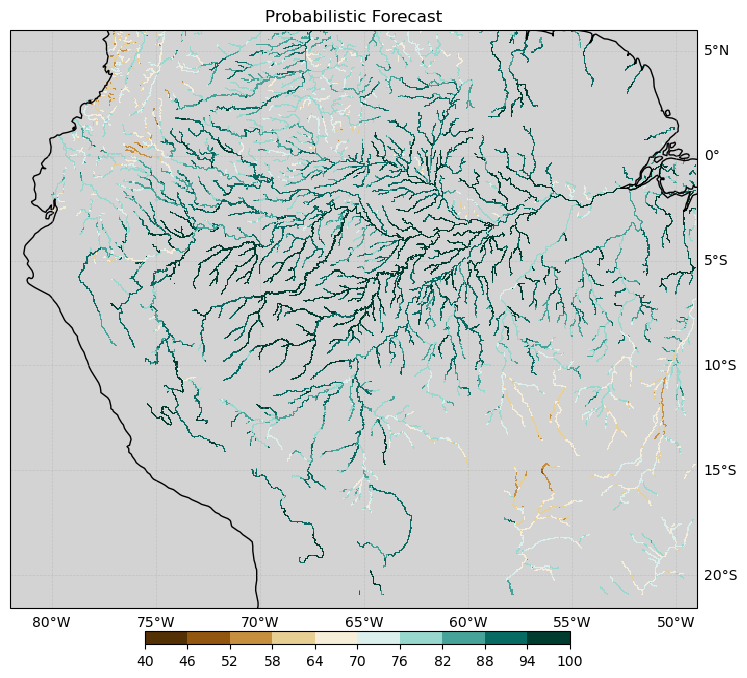

: 

In [ ]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Define your range of values
vmin, vmax = 40, 100  # Range of values

# Create 10 discrete colors from the 'BrBG' colormap
n_colors = 10
cmap = plt.cm.get_cmap('BrBG', n_colors)

# Define the boundaries for normalization
bounds = np.linspace(vmin, vmax, n_colors+1)

# Create a BoundaryNorm to normalize the colormap based on the bounds
norm = BoundaryNorm(boundaries=bounds, ncolors=n_colors)

# Create the figure and axes
fig, ax = plt.subplots(
    1, 1, 
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(8.5, 6.5)
)
# Plot the GeoDataFrames with the normalized colormap
fcst_gdf.plot(column='anomaly', ax=ax, cmap=cmap, linewidth=0.5, norm=norm)
#retro_gdf_plot = retro_gdf.plot(column='streamflow', ax=axs[1], cmap=cmap, linewidth=0.5, norm=norm)
#fcst_gdf.plot(column='streamflow', ax=axs[0], cmap=cmap, linewidth=0.5)

lis_output_bounds = [-82, -49, -21, 6] ## [Min lon, max lon, min lat, max lat]

# Common map features
#for ax in axs.flatten():
ax.set_extent(lis_output_bounds)
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#amazon_gdf.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.5)
ax.set_facecolor('lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False

# Titles and labels
ax.set_title('Probabilistic Forecast')
#ax.set_title('Determinisitc Streamflow')
#axs[0].text(-84, -7.5, 'Streamflow', rotation=90, fontsize=14, va='center')

# Add a single colorbar below the figure
cbar_ax = fig.add_axes([0.25, 0, 0.5, 0.02])  # [left, bottom, width, height]
cbar = colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10)

# Adjust layout and save the figure
fig.tight_layout()  # Leave space for the colorbar at the bottom
#fig.savefig(output_directory + 'streamflow_july_2024.png', dpi=300, bbox_inches='tight')